In [2]:
from starry.kepler import Primary, Secondary, System
import numpy as np
import slepian
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math
np.random.seed(264)

In [3]:
def changeOfBasis(L):
    """Change of basis matrix."""
    return np.array(slepian.slepianToHarmonic(L),dtype=float)

In [4]:
def setCoeffs(X,r,planet):
    """Takes a harmonic vector X and sets the starry map parameters."""
    
    # Pull out the Y0,0 coefficient X0 to set L
    X0 = X[0] 
    
    # Renormalize so that X0 = 1
    X = X/X0 
    
    # Set luminosity
    planet.L = r*X0 
    
    # Set map coefficients
    planet[1,:] = X[1:] 
    
    return

In [5]:
def getLightCurve(X,par):
    """Creates a planet-star system and generate the planet light curve."""
    
    r,time,star,planet,L,C = par
    
    # Set map coefficients
    setCoeffs(X,r,planet)
    
    # Instantiate the system
    system = System(star, planet)
    
    # Compute the flux
    system.compute(time)
    flux = planet.lightcurve
    
    return flux

In [6]:
def lnPrior(X):
    """Log prior probability."""
    
    # Map coefficents should be |X| < 1 and 
    # X0 > 0 so that luminosity is positive. 
    if np.any(X < -1) or np.any(X > 1) or (X[0] <= 0): 
        return -np.inf
    else:
        return 0

In [7]:
def lnLike(var,par,flux,flux_err):
    """Log likelihood."""
    
    # Seperate arguments
    r,time,star,planet,L,C = par
    T = var[:(L+1)**2]
    
    # Convert from slepian to harmonic vector.
    X = np.dot(C,T) 
    
    # Check that X fits the priors.
    l = lnPrior(X)
    if np.isinf(l):
        return l
    
    # Create a system and get the computed flux.
    c_flux = getLightCurve(X,par)
    
    # Caluculate log likelihood.
    like = np.sum(((flux - c_flux)/flux_err)**2 + np.log(2*np.pi*flux_err**2))
    l += -0.5*like
    
    return l

In [8]:
def maxLike(lnLike,var_guess,par,flux,flux_err):
    """Maximum likelihood solution for slepian coefficients."""
    
    # Define negative log likelihood
    nlnLike = lambda *args: -lnLike(*args)

    # Find the numerical optimum of the likelihood function
    soln = minimize(nlnLike, var_guess, args = (par,flux,flux_err),method='Nelder-Mead')
    var_msol = soln.x

    return var_msol

In [9]:
"""Initial Settings"""
# Time
time = np.linspace(-0.1, 0.1, 1000)

# Bandlimit
L = 1
C = changeOfBasis(L)

# Instantiate star and planet
star = Primary()
planet = Secondary(L)

planet.a = 5 # Orbital semi-major axis in units of the stellar radii.
planet.inc = 87 # Orbital inclination (90 degrees is an edge-on orbit)
planet.porb = 1 # Orbital period in Julian days
planet.prot = 1 # Rotation period in days (synchronous if prot=porb)
#planet.ecc = 0 # Eccentricity
#planet.w = 0  # Longitude of pericenter in degrees (meaningless for ecc=0)
planet.tref = 0.5 # Time of transit in Julian days
r = 0.01

par = r,time,star,planet,L,C

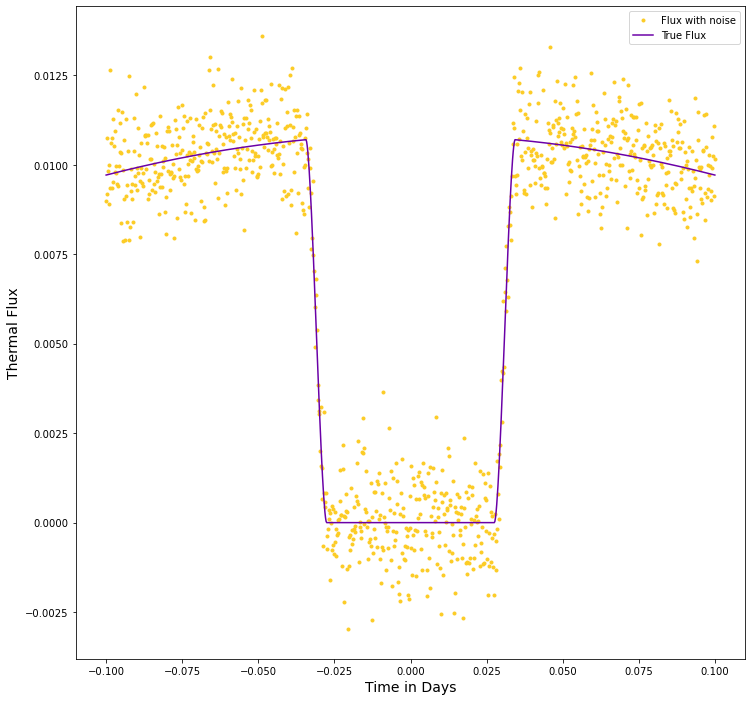

In [10]:
"""Create synthetic data."""

#Define the true variables
T_true = np.array([0.7,0.3,0.0,0.0])
X_true = np.dot(C,T_true)
var_true = X_true

# Generate the light curve for true planet
flux_true = getLightCurve(var_true,par)

var_true = T_true

# Add noise
flux_err = 0.001
flux = flux_true + flux_err*np.random.randn(1000)

# Print and plot
plt.figure(figsize=(12,12))
plt.plot(time,flux, color = '#FCCC25',marker = '.',linestyle ='None',label = 'Flux with noise')
plt.plot(time,flux_true, color = '#6A00A7', marker = 'None', label = 'True Flux')
plt.legend(fontsize=10)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

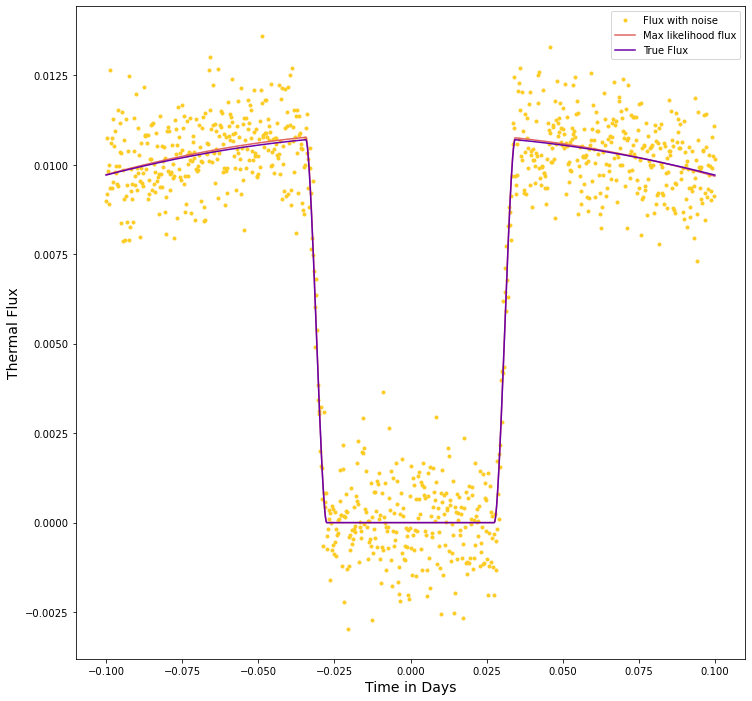

In [11]:
"""Find the max likelihood solution."""

# Define a guess
var_guess = np.array([0.1,0.1,0,0])

# Find the max likelihood variables
var_msol = maxLike(lnLike,var_guess,par,flux,flux_err)

# Print and plot max likelihood results
T_msol = var_msol[:(L+1)**2]

labels = ["T_1","T_2","T_3","T_4"]
for i in range(len(T_msol)):
    txt = "\mathrm{{{1}}} = {0:.3f}"
    txt = txt.format(T_msol[i], labels[i])
    display(Math(txt))
    
X_msol = np.dot(C,T_msol)
flux_msol = getLightCurve(X_msol,par)

plt.figure(figsize=(12,12))
plt.plot(time,flux, color = '#FCCC25',marker = '.',linestyle ='None',label = 'Flux with noise')
plt.plot(time,flux_msol, color = '#E06461', marker = 'None', label = 'Max likelihood flux')
plt.plot(time,flux_true, color = '#6A00A7', marker = 'None', label = 'True Flux')
plt.legend(fontsize=10)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()

In [12]:
"""Run an MCMC chain"""

# Initialize around the max likelihood solution
var_init = var_msol + flux_err*np.random.randn(32,len(var_msol)) #32 random walkers 
nwalkers,ndim = var_init.shape

nsteps = 5000

# Run an MCMC chain
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnLike, args = (par,flux,flux_err))
sampler.run_mcmc(var_init, nsteps, progress=True)                                

100%|██████████| 5000/5000 [01:52<00:00, 44.29it/s]


State([[ 6.97572695e-01  5.60523616e-01 -7.74104787e-03  1.27110319e-02]
 [ 6.99284020e-01  2.99136569e-01  9.03737882e-03 -7.62400695e-02]
 [ 7.10788248e-01  2.72131673e-01  1.03293869e-02  1.98752434e-01]
 [ 7.06940433e-01  7.95828646e-02  8.63092635e-03 -4.01930728e-02]
 [ 7.03135754e-01  2.72571641e-01 -5.11510186e-03  4.74748322e-02]
 [ 7.09704629e-01  1.57169314e-01  4.65518752e-03  2.76036087e-02]
 [ 7.11820843e-01 -4.28688817e-02  8.68458548e-03  1.20014014e-02]
 [ 7.04312733e-01  1.89324748e-01  1.21718007e-03  3.77918747e-02]
 [ 7.01176951e-01  3.64816414e-01 -2.99349641e-03  1.21987971e-01]
 [ 7.17476700e-01  2.26940266e-02 -6.13802266e-03  1.25077986e-01]
 [ 6.96484059e-01  3.38041552e-01  1.06765646e-02 -5.10456441e-02]
 [ 6.90543737e-01  5.09278148e-01 -7.34674678e-03 -8.90645266e-02]
 [ 6.86112656e-01  7.64407556e-01  9.58098865e-03  1.76706082e-01]
 [ 6.97330923e-01  3.86735337e-01 -1.07230285e-03  1.44087368e-01]
 [ 7.02909723e-01  2.75093377e-01  1.42084574e-02  1.852

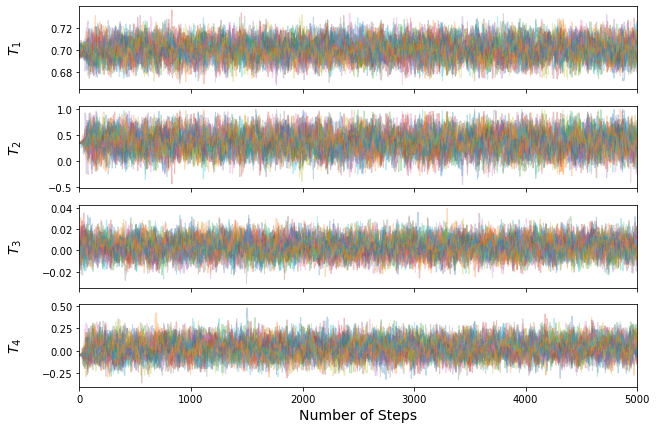

In [13]:
"""Plot the chains"""

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labelsp = [r"$T_1$", r"$T_2$", r"$T_3$",r"$T_4$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3,lw = 1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labelsp[i],fontsize=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Number of Steps",fontsize=14);

In [14]:
"""Burn in."""

# An estimate of the integrated autocorrelation time
tau = sampler.get_autocorr_time()
print(tau)

#Set the burn-in
nburn = 100

[49.26664842 49.01725275 46.97361923 45.67325557]


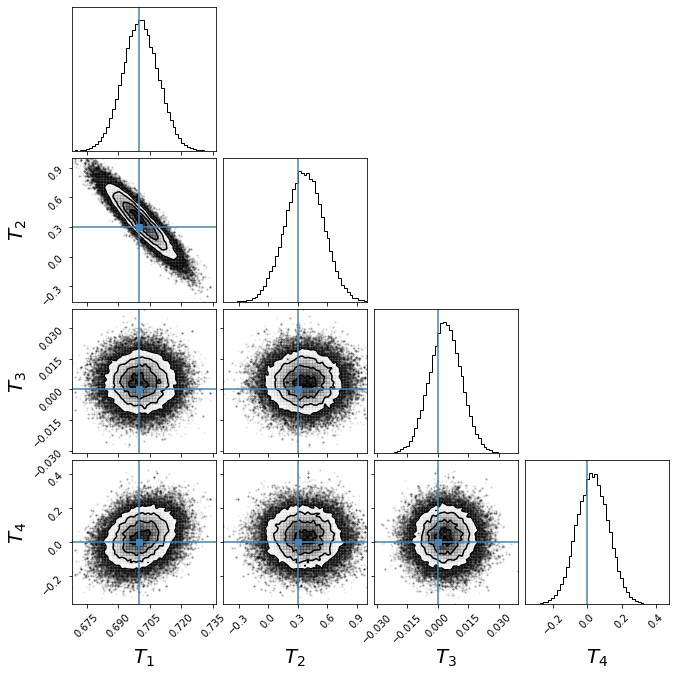

In [15]:
"""Corner plot"""

# Plot the corner plot
samples = sampler.chain[:, nburn:, :].reshape(nwalkers * (nsteps-nburn), ndim)
fig = corner.corner(samples, labels=labelsp, bins=50, truths = var_true);
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

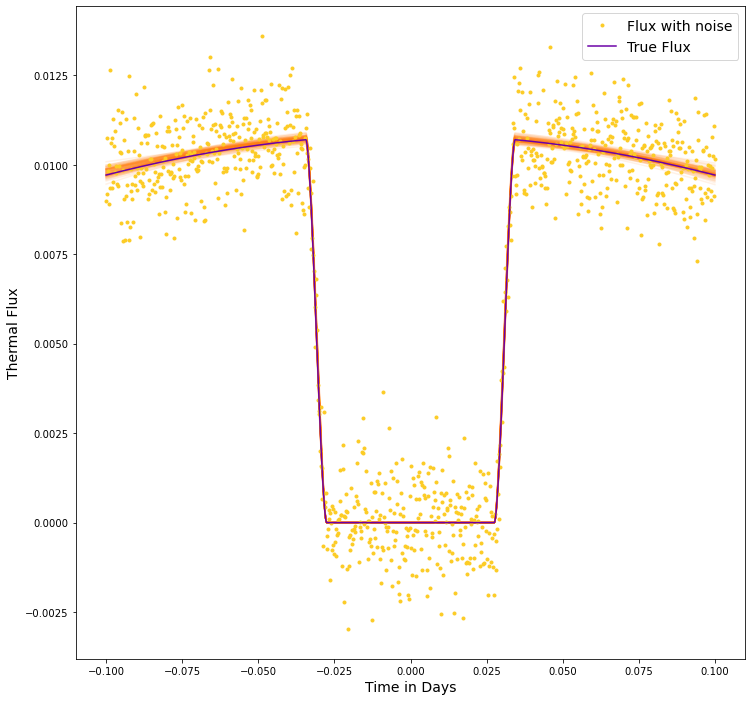

In [16]:
"""Sample Solutions"""

flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)

plt.figure(figsize=(12,12))
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = getLightCurve(np.dot(C,flat_samples[ind]),par)
    plt.plot(time, sample, "C1", alpha=0.1)

plt.plot(time,flux, color = '#FCCC25',marker = '.',linestyle ='None',label = 'Flux with noise')
plt.plot(time, flux_true, color = '#6A00A7', marker = 'None', label = 'True Flux')
plt.legend(fontsize=14)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

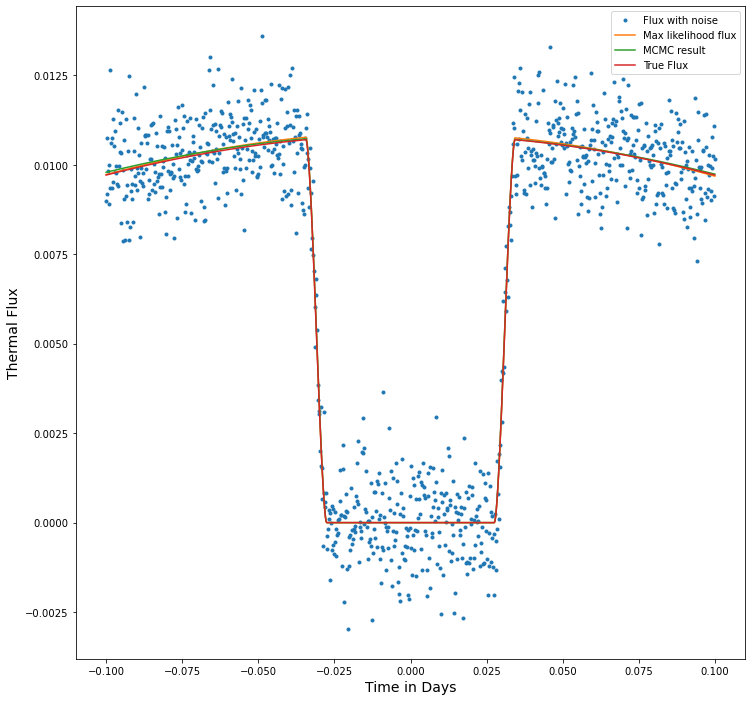

In [32]:
"""MCMC Solution."""

T_r = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    T_r.append(mcmc[1])
    
    
X_r = np.dot(C,T_r)
flux_r = getLightCurve(X_r,par)

plt.figure(figsize=(12,12))
plt.plot(time,flux,marker = '.',linestyle ='None',label = 'Flux with noise')
plt.plot(time,flux_msol, marker = 'None', label = 'Max likelihood flux')
plt.plot(time,flux_r, marker = 'None', label = 'MCMC result')
plt.plot(time,flux_true, marker = 'None', label = 'True Flux')
plt.legend(fontsize=10)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()